In [2]:
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor as XGBR,XGBClassifier as XGBC,plot_importance
from lightgbm import LGBMRegressor as LGBMR,LGBMClassifier as LGBMC,plot_importance,Booster
from sklearn.ensemble import RandomForestRegressor as RFR,AdaBoostRegressor as ABR
from numpy import sort
from sklearn.linear_model import LogisticRegression as LR
from mlxtend.regressor import StackingCVRegressor as SCVR
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor as MLPR
from pyecharts.charts import Bar
import pyecharts.options as opts

/Users/caroline/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
%%time
train_data = pd.read_parquet('/Users/caroline/Downloads/train_data.parquet')
test_data = pd.read_parquet('/Users/caroline/Downloads/test_data.parquet')

CPU times: user 17.8 s, sys: 4.69 s, total: 22.5 s
Wall time: 45.7 s


是否违约取决于用户最近一次帐期后的120天是否支付，所以用户的最后一次报表数据至关重要，它将是我们用于训练的数据主要来源，但是大部分用户有13个月的账期数据，这其中或许也隐藏着信息，把历史数据用于弥补当前账期一些缺失或异常数据带来的误差不失为一种策略。

首先我们取最后一个账期的数据，对全部特征做相关性分析，初步提取出和目标（target）相关系数最大的一些特征（top_features），后续将提取这些特征的历史数据来构建新特征。

In [187]:
data = train_data.groupby('customer_ID').tail(1)
corr_matrix = data.corr()

In [188]:
corr_target = pd.DataFrame(corr_matrix.target)
top_features = corr_target[(abs(corr_target['target'])>=0.5)&(abs(corr_target['target'])!=1)].index.to_list()
top_features

['P_2',
 'B_2',
 'B_3',
 'D_44',
 'D_48',
 'B_7',
 'B_9',
 'D_55',
 'D_61',
 'B_18',
 'B_33']

数据集的特征都是匿名的，分为以下一般类别：

D_* = 拖欠变量

S_* = 支出变量

P_* = 付款变量

B_* = 平衡变量

R_* = 风险变量

考虑通过考察特征类别的共性，通过特征组合构建新的特征。


In [207]:
data['R_12'].value_counts(dropna=False)

 1.006702    17
 1.001040    16
 1.000950    16
 1.000563    16
 1.007287    16
 1.002763    16
 1.000380    15
 1.005476    15
 1.005637    15
 1.007368    15
 1.002328    15
 1.004805    15
 1.008876    15
 1.006646    15
 1.002083    15
 1.005855    15
 1.000723    15
 1.005594    15
 1.003522    15
 1.001481    15
 1.004294    15
 1.004558    15
 1.002116    15
 1.004810    15
 1.001397    15
 1.003372    15
 1.000134    14
 1.001542    14
 1.008426    14
 1.009115    14
 1.004278    14
 1.008459    14
 1.002477    14
 1.003198    14
 1.008119    14
 1.005458    14
 1.003064    14
 1.009256    14
 1.006558    14
 1.000884    14
 1.001755    14
 1.002048    14
 1.001753    14
 1.001923    14
 1.004465    14
 1.009002    14
 1.005809    14
 1.002359    14
 1.009474    14
 1.006000    14
 1.002235    14
 1.007210    14
 1.006166    14
 1.007322    14
 1.008275    14
 1.003558    14
 1.005503    14
 1.002969    14
 1.002461    14
 1.000646    14
 1.007727    14
 1.008853    14
 1.00718

In [4]:
r_bin = ['R_2', 'R_4', 'R_15', 'R_19', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_28', 'R_7', 'R_12', 'R_14']

In [5]:
train  = train_data[['customer_ID'] + r_bin]

In [10]:
train.R_7.fillna(0).astype(np.float32).value_counts()
# .describe(percentiles=[0.9])

0      5475972
1        20909
2         9191
3         4456
4         2500
        ...   
120          1
242          1
315          1
164          1
188          1
Name: R_7, Length: 172, dtype: int64

In [5]:
#缺失值查看
n_df_train = pd.DataFrame(train_data.isnull().sum(axis=0),columns=['n_rate_train'])/len(train_data)
n_df_test = pd.DataFrame(test_data.isnull().sum(axis=0),columns=['n_rate_test'])/len(test_data)
n_df = pd.merge(n_df_train,n_df_test,how='left',left_index=True,right_index=True)

In [6]:
mix_df = n_df.merge(corr_target,how='outer',left_index=True,right_index=True)

In [7]:
#剔除和目标关联度小或缺失严重的特征
drop_features = mix_df[(abs(mix_df['target'])<0.05)|(mix_df['n_rate_train']>0.5)].index.to_list()
#保留B_17,B_42 
drop_features.remove('B_17')
drop_features.remove('B_42')
drop_features.append('S_2')#日期列


In [8]:
drop_features

['B_10',
 'B_12',
 'B_13',
 'B_15',
 'B_26',
 'B_27',
 'B_29',
 'B_36',
 'B_39',
 'B_40',
 'D_102',
 'D_105',
 'D_106',
 'D_108',
 'D_109',
 'D_110',
 'D_111',
 'D_132',
 'D_134',
 'D_135',
 'D_136',
 'D_137',
 'D_138',
 'D_142',
 'D_144',
 'D_42',
 'D_49',
 'D_50',
 'D_53',
 'D_56',
 'D_66',
 'D_69',
 'D_73',
 'D_76',
 'D_82',
 'D_87',
 'D_88',
 'D_93',
 'R_14',
 'R_18',
 'R_23',
 'R_26',
 'R_28',
 'R_9',
 'S_12',
 'S_17',
 'S_18',
 'S_19',
 'S_26',
 'S_5',
 'S_9',
 'S_2']

In [9]:
train_data = train_data.drop(columns=drop_features)
test_data = test_data.drop(columns=drop_features)

In [10]:
top_features.append('customer_ID')
top_features = list(set(top_features))

In [11]:
#把重要特征的均值、中值等作为🆕特征
extra_features = train_data[top_features].groupby('customer_ID').agg(['mean','median','std','sum','max','min'])
train_data = train_data.groupby('customer_ID').tail(1)
train_data = pd.merge(train_data,extra_features,how='left',on='customer_ID')

/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_15513/3749302612.py:4: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  train_data = pd.merge(train_data,extra_features,how='left',on='customer_ID')


In [12]:
extra_features = test_data[top_features].groupby('customer_ID').agg(['mean','median','std','sum','max','min'])
test_data = test_data.groupby('customer_ID').tail(1)
test_data = pd.merge(test_data,extra_features,how='left',on='customer_ID')

/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_15513/4212107262.py:3: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  test_data = pd.merge(test_data,extra_features,how='left',on='customer_ID')


In [13]:
features_fill_na_mode = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64','D_68']
for feature_mode in features_fill_na_mode:
    mode_value = train_data[feature_mode].value_counts().sort_values(ascending=False).index[0]
    train_data[feature_mode] = train_data[feature_mode].fillna(mode_value)
for feature_mode in features_fill_na_mode:
    mode_value = test_data[feature_mode].value_counts().sort_values(ascending=False).index[0]
    test_data[feature_mode] = test_data[feature_mode].fillna(mode_value)
    

In [14]:
train_data[['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64','D_68']].isnull().sum(axis=0)

B_30     0
B_38     0
D_114    0
D_116    0
D_117    0
D_120    0
D_126    0
D_63     0
D_64     0
D_68     0
dtype: int64

In [15]:
train_data.fillna(train_data.median(),inplace=True)
test_data.fillna(test_data.median(),inplace=True)

/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_15513/3665293125.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_data.fillna(train_data.median(),inplace=True)
/var/folders/7l/tgtyfd113vbfk2nw_xks1v000000gn/T/ipykernel_15513/3665293125.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  test_data.fillna(test_data.median(),inplace=True)


In [16]:
pd.set_option('display.max_row', None)
test_data.isnull().sum(axis=0)

customer_ID       0
P_2               0
D_39              0
B_1               0
B_2               0
R_1               0
S_3               0
D_41              0
B_3               0
D_43              0
D_44              0
B_4               0
D_45              0
B_5               0
R_2               0
D_46              0
D_47              0
D_48              0
B_6               0
B_7               0
B_8               0
D_51              0
B_9               0
R_3               0
D_52              0
P_3               0
B_11              0
S_6               0
D_54              0
R_4               0
S_7               0
S_8               0
D_55              0
R_5               0
D_58              0
B_14              0
D_59              0
D_60              0
D_61              0
S_11              0
D_62              0
D_63              0
D_64              0
D_65              0
B_16              0
B_17              0
B_18              0
B_19              0
B_20              0
D_68              0


In [17]:
test_data.shape

(924621, 180)

In [18]:
train_data.shape

(458913, 181)

In [19]:
Y = train_data.target.values.ravel()
train_data = train_data.drop(columns=['target'])
train_data.shape

(458913, 180)

In [20]:
total = pd.concat([train_data,test_data])
total = total.set_index('customer_ID')
total.shape

(1383534, 179)

In [31]:
categories = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_68']
X = pd.get_dummies(total,columns=categories)

In [32]:
X.columns

Index([     'P_2',     'D_39',      'B_1',      'B_2',      'R_1',      'S_3',
           'D_41',      'B_3',     'D_43',     'D_44',
       ...
        'D_63_XZ',   'D_64_O',   'D_64_R',   'D_64_U', 'D_68_1.0', 'D_68_2.0',
       'D_68_3.0', 'D_68_4.0', 'D_68_5.0', 'D_68_6.0'],
      dtype='object', length=209)

In [33]:
X.shape

(1383534, 209)

In [34]:
X.columns = [str(i).replace('(','').replace(')','').replace(', ','_').replace('\'','') for i in X.columns.to_list()]

In [35]:
X_predict = X.iloc[458913:,:]
X_train_or_test = X.iloc[:458913,:]

In [36]:
X_train_or_test.shape

(458913, 209)

In [37]:
Y.shape

(458913,)

In [100]:
X_train,X_test, y_train, y_test =train_test_split(X_train_or_test,Y,test_size=0.3)

In [29]:
def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

In [ ]:
params ={
    'boosting_type':'gbdt',
    'learning_rate':0.05,
    'n_estimators':900,
    'min_split_gain':0,
    'min_child_weight':0.001,
    'max_depth':5,
    'num_leaves':31,
}

In [95]:
folds = KFold(n_splits=5, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(folds.split(X_train_or_test, Y)):
    X_train, y_train = X_train_or_test.iloc[train_idx,:], Y[train_idx]
    X_val, y_val = X_train_or_test.iloc[val_idx,:], Y[val_idx]
    lgbm = LGBMR(**params,random_state=1).fit(X_train, y_train)
    lgbm.booster_.save_model('LGBMmodel_{}.txt'.format(fold))
    val_predict = lgbm.predict(X_val) 
    y_val1 = pd.DataFrame(y_val)
    y_val1.columns = ['target']
    val_predict1 = pd.DataFrame(val_predict)
    val_predict1.columns = ['prediction']
    s = amex_metric(y_val1,val_predict1)
    print("n_fold:{},score:{}".format(fold,s))

n_fold:0,score:0.7844928428285869
n_fold:1,score:0.7799476155859844
n_fold:2,score:0.7766861819651252
n_fold:3,score:0.7859713008051517
n_fold:4,score:0.774060102825594


In [214]:
lgbm = LGBMC(**params,random_state=1).fit(X_train,y_train)
test_predict = lgbm.predict(X_test) 
y_train_predict = lgbm.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: P_2, D_39, B_1, B_2, R_1, S_3, D_41, B_3, D_43, D_44, B_4, D_45, B_5, R_2, D_46, D_47, D_48, B_6, B_7, B_8, D_51, B_9, R_3, D_52, P_3, B_11, S_6, D_54, R_4, S_7, S_8, D_55, R_5, D_58, B_14, D_59, D_60, D_61, S_11, D_62, D_65, B_16, B_17, B_18, B_19, B_20, R_6, S_13, B_21, B_22, D_70, D_71, D_72, S_15, B_23, P_4, D_74, D_75, B_24, R_7, D_77, B_25, D_78, D_79, R_8, S_16, D_80, R_10, R_11, D_81, R_12, B_28, R_13, D_83, R_15, D_84, R_16, D_86, R_17, B_31, R_19, B_32, S_20, R_20, R_21, B_33, D_89, R_22, D_91, D_92, D_94, R_24, R_25, D_96, S_22, S_23, S_24, S_25, D_103, D_104, D_107, B_37, R_27, D_112, S_27, D_113, D_115, D_118, D_119, D_121, D_122, D_123, D_124, D_125, D_127, D_128, D_129, B_41, D_130, D_131, D_133, D_139, D_140, D_141, D_143, D_145, D_44_mean, D_44_median, D_44_std, D_44_sum, D_44_max, D_44_min, B_9_mean, B_9_median, B_9_std, B_9_sum, B_9_max, B_9_min, B_3_mean, B_3_median, B_3_std, B_3_sum, B_3_max, B_3_min, D_61_mean, D_61_median, D_61_std, D_61_sum, D_61_max, D_61_min, D_48_mean, D_48_median, D_48_std, D_48_sum, D_48_max, D_48_min, B_7_mean, B_7_median, B_7_std, B_7_sum, B_7_max, B_7_min, D_55_mean, D_55_median, D_55_std, D_55_sum, D_55_max, D_55_min, B_30_0.0, B_30_1.0, B_30_2.0, B_38_1.0, B_38_2.0, B_38_3.0, B_38_4.0, B_38_5.0, B_38_6.0, B_38_7.0, D_114_0.0, D_114_1.0, D_116_0.0, D_116_1.0, D_117_-1.0, D_117_1.0, D_117_2.0, D_117_3.0, D_117_4.0, D_117_5.0, D_117_6.0, D_120_0.0, D_120_1.0, D_126_0.0, D_126_1.0, D_63_CL, D_63_CO, D_63_CR, D_63_XL, D_63_XM, D_63_XZ, D_64_O, D_64_R, D_64_U, D_68_1.0, D_68_2.0, D_68_3.0, D_68_4.0, D_68_5.0, D_68_6.0, c_PD_239, c_PB_29, c_PR_21, c_BBBB, c_BBBB1, c_BBBB2, c_RRR0, c_RRR1, c_PD_348, c_PD_355, c_PD_439, c_PB_49, c_PR_41

In [53]:
for i in range(5,25,5):
    for j in range(100,1500,100):
        lgbm = LGBMR(learning_rate=i/100,n_estimators=j,random_state=1,).fit(X_train,y_train)
        test_predict = lgbm.predict(X_test) 
        y_train_predict = lgbm.predict(X_train)
        y_test1 = pd.DataFrame(y_test)
        y_test1.columns = ['target']
        test_predict1 = pd.DataFrame(test_predict)
        test_predict1.columns = ['prediction']
        score = amex_metric(y_test1,test_predict1)
        print("i:{},j:{},score:{}".format(i,j,score))


i:5,j:100,score:0.7694091437921491
i:5,j:200,score:0.7771272018492108
i:5,j:300,score:0.7782785756001841
i:5,j:400,score:0.7794050108505788
i:5,j:500,score:0.7796143287571342
i:5,j:600,score:0.7794641475046262
i:5,j:700,score:0.7801042631409318
i:5,j:800,score:0.7801961274903078
i:5,j:900,score:0.780365176219121
i:10,j:100,score:0.7758545946278159
i:10,j:200,score:0.7766311573260153
i:10,j:300,score:0.7770152373417021
i:10,j:400,score:0.7766558400167396
i:10,j:500,score:0.7765391860451791
i:10,j:600,score:0.7758375611759212
i:10,j:700,score:0.7754795203139124
i:10,j:800,score:0.7753927281485813
i:10,j:900,score:0.774736636903081
i:15,j:100,score:0.7757086283126186
i:15,j:200,score:0.7752713880621701
i:15,j:300,score:0.7741363186217216
i:15,j:400,score:0.7737342370209888
i:15,j:500,score:0.7730426525154546
i:15,j:600,score:0.7718286419974588
i:15,j:700,score:0.7709401160254836
i:15,j:800,score:0.770207848400712
i:15,j:900,score:0.7691370763867331


In [56]:
for i in range(2,32,1):
    for j in range(1):
        lgbm = LGBMR(learning_rate=0.05,n_estimators=900,max_depth=5,num_leaves=i,random_state=1,).fit(X_train,y_train)#0.7754706768660901
        test_predict = lgbm.predict(X_test) 
        y_train_predict = lgbm.predict(X_train)
        y_test1 = pd.DataFrame(y_test)
        y_test1.columns = ['target']
        test_predict1 = pd.DataFrame(test_predict)
        test_predict1.columns = ['prediction']
        score = amex_metric(y_test1,test_predict1)
        print("i:{},j:{},score:{}".format(i,j,score))


i:2,j:0,score:0.753476591987293
i:3,j:0,score:0.7672161869723174
i:4,j:0,score:0.7716975169725918
i:5,j:0,score:0.7738666386133443
i:6,j:0,score:0.7760349990825586
i:7,j:0,score:0.7775382386851677
i:8,j:0,score:0.7780849990554091
i:9,j:0,score:0.778851524958281
i:10,j:0,score:0.7772517692592368
i:11,j:0,score:0.7790456296781914
i:12,j:0,score:0.7790041324756087
i:13,j:0,score:0.7793094752848573
i:14,j:0,score:0.7796851012123621
i:15,j:0,score:0.7795566222874099
i:16,j:0,score:0.7801256149825556
i:17,j:0,score:0.7802101690602387
i:18,j:0,score:0.7798720100240613
i:19,j:0,score:0.779478057380554
i:20,j:0,score:0.779672124862352
i:21,j:0,score:0.7796698712836733
i:22,j:0,score:0.7803733271974241
i:23,j:0,score:0.7795642971571879
i:24,j:0,score:0.7807396583666696
i:25,j:0,score:0.7796473958629344
i:26,j:0,score:0.7796675107562564
i:27,j:0,score:0.7796634394528625
i:28,j:0,score:0.7787157081470407
i:29,j:0,score:0.7791976166424368
i:30,j:0,score:0.7794397730018843
i:31,j:0,score:0.780351779

In [ ]:
xgbr =  XGBR(n_estimators=70,max_depth=5,random_state=123).fit(X_train,y_train)
test_predict = xgbr.predict(X_test) 
y_train_predict = xgbr.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score

/Users/caroline/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.7680404821327709

In [ ]:
nn= MLPR(random_state=123).fit(X_train,y_train)
test_predict = nn.predict(X_test) 
y_train_predict = xgbr.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score

0.7694922364382959

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

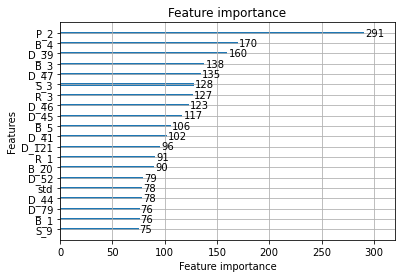

In [ ]:
plot_importance(lgbm,max_num_features=20)

In [103]:
lgbm = LGBMR(n_estimators=240,learning_rate=0.015,random_state=123)
xgbr =  XGBR(n_estimators=70,max_depth=5,random_state=123)
nn= MLPR()
scvr =  SCVR(regressors=[lgbm,xgbr], meta_regressor=nn,random_state=123).fit(X_train,y_train)
test_predict = scvr.predict(X_test)
y_train_predict = scvr.predict(X_train)
y_test1 = pd.DataFrame(y_test)
y_test1.columns = ['target']
test_predict1 = pd.DataFrame(test_predict)
test_predict1.columns = ['prediction']
score = amex_metric(y_test1,test_predict1)
score

KeyboardInterrupt: 

In [ ]:
prediction = scvr.predict(X_predict)
bst = Booster(model_file='LGBMmodel_5.txt')
predictions = bst.predict(X_predict)
submission_1 = pd.DataFrame({"customer_ID":X_predict.index,"prediction":prediction})
submission_1.to_csv('submission.csv', index=False)

In [59]:
prediction = lgbm.predict(X_predict)

In [60]:
prediction.mean()

0.2581252869351814

In [62]:
prediction[prediction>1]=1
prediction[prediction<0]=0


In [63]:
submission = pd.DataFrame({"customer_ID":X_predict.index,"prediction":prediction})

<AxesSubplot:>

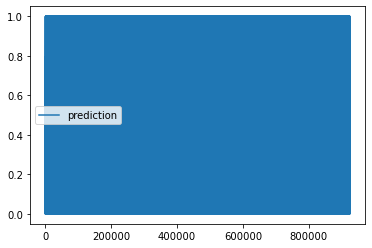

In [64]:
submission.plot()

In [65]:
submission.head()

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.000000
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.002483
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.071128
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.314556
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.793487


In [66]:
submission.to_csv('submission.csv', index=False)

In [212]:
X_train.head()

,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_43,D_44,...,c_BBBB,c_BBBB1,c_BBBB2,c_RRR0,c_RRR1,c_PD_348,c_PD_355,c_PD_439,c_PB_49,c_PR_41
customer_ID,,,,,,,,,,,,,,,,,,,,,
2465e53326b86cbfbc79585632bf0ac6ec54f9bfc3dca6b0784ca42acda3ae01,0.91,0.00,0.00,1.01,0.00,0.16,0.00,0.00,0.14,0.01,...,0.31,-1.04,0.06,0.53,0.19,0.14,0.14,0.00,0.00,0.00
138a5df5d520b3a88bcbaec713515bff21ff8dca89b51d768f5e0bb0eab16587,0.96,0.01,0.02,0.82,0.25,0.09,0.01,0.02,0.50,0.01,...,0.05,-0.72,0.04,39.02,0.22,0.48,0.35,0.01,0.00,0.25
885f1bb34ea169940d30d37404b1e6f8f4d83be332cf392829f140b4aa5fa83b,0.64,0.33,0.05,0.64,0.00,0.18,0.75,0.02,0.02,0.00,...,5.80,0.63,0.33,1.03,0.18,0.82,0.51,0.33,0.34,0.00
1e6d6320ebd8efe062e43f955db5f5ab919bb8230f9d0d1438c356cb8b013c78,0.87,0.04,0.48,0.04,0.00,0.15,0.00,0.48,0.05,0.13,...,0.15,0.87,2.31,0.63,0.04,0.80,0.76,0.04,0.17,0.00
574e5df164a3f8f36a45e110f302c01bd581e4d5f273f167291c099701acf82d,0.42,0.33,0.05,0.66,0.00,0.66,0.00,0.02,0.06,0.26,...,0.01,0.78,0.52,8.39,0.02,5.41,2.91,0.33,0.00,0.00
